# First Model
Tristan Miller, 9/12/2019

Currently, I have one mp3, and one text file with corresponding chord information.  My goal is to build a model trained on the first half of the song, which predicts the chords of the second half.  This is to be as simple a model as possible, using logistic regression on the constant-Q transform of the track, segmented in 1 second blocks.

The song is "I saw her standing there" by The Beatles.  The chord file was downloaded in csv format from http://www.isophonics.net/content/reference-annotations-beatles.

## Table of contents

- [Setup](#Setup)
- [Loading music file](#Loading-music-file)
- [Loading chord file](#Loading-chord-file)
- [Training model](#Training-model)

## Setup
[Return to top](#Table-of-contents)

In [138]:
from IPython.display import Audio, display
#import urllib.request
import numpy as np
import scipy.stats
#import seaborn as sns
import pandas as pd
#import scikit_posthocs as sp
import matplotlib.pyplot as plt
#from matplotlib import gridspec
#from matplotlib.transforms import BlendedGenericTransform
#import scikit_posthocs as sp
#from urllib.request import urlopen
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
import librosa
import librosa.display
import sklearn

In [17]:
chord_dir = "../Data/Isophonics/"
chord_filename = "01_-_I_Saw_Her_Standing_There.lab.txt"
mp3_dir = "../Data/YouTube/"
mp3_filename = "I saw Her Standing There--The Beatles.mp3"

## Loading music file
[Return to top](#Table-of-contents)

In [19]:
track,sr = librosa.load(mp3_dir + mp3_filename)

In [33]:
print(f"size of track: {track.shape[0]:d}")
print(f"sampling rate: {sr:d} Hz")
print(f"length of track: {track.shape[0]/sr:.2f} s")

size of track: 3835524
sampling rate: 22050 Hz
length of track: 173.95 s


In [38]:
int(track.shape[0]/2)

1917762

In [109]:
track_train = track[0:int(track.shape[0]/2)]
track_test = track[int(track.shape[0]/2):]

In [40]:
def testfunc(a=10):
    print(a)

In [45]:
testfunc(**{'a':5})

5


In [110]:
cqt_options = {'sr':sr,
               'hop_length':int(sr/64)*64, #approx 1 s
               'fmin':32.7, #minimum frequency, in Hz
               'n_bins':252, #7 octaves
               'bins_per_octave':36,
               'tuning':0.0}
spec_train = librosa.cqt(track_train, **cqt_options)
spec_test = librosa.cqt(track_test, **cqt_options)
#drop the first and last columns, since I don't trust whatever it's doing for padding.
spec_train = spec_train[:,1:-1]
spec_test = spec_test[:,1:-1]

In [111]:
print(spec_train.shape)
print(spec_test.shape)

(252, 86)
(252, 86)


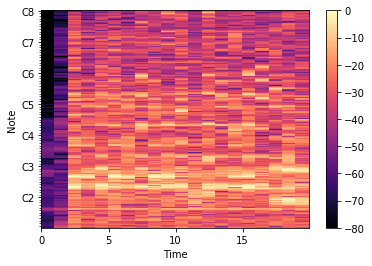

In [140]:
display_options = {'sr':cqt_options['sr'],
                  'hop_length':cqt_options['hop_length'],
                  'fmin':cqt_options['fmin'],
                  'bins_per_octave':cqt_options['bins_per_octave'],
                  'y_axis':'cqt_note',
                  'x_axis':'time'}
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec_train[:,0:20]), ref=np.max),**display_options)
plt.colorbar()

## Loading chord file
[Return to top](#Table-of-contents)

In [73]:
chords = pd.read_csv(chord_dir + chord_filename,sep=" ",
                     header=None,names=["start_time","end_time","chord"])
chords.head()

,start_time,end_time,chord
0,0.000000,2.612267,N
1,2.612267,11.459070,E
2,11.459070,12.921927,A
3,12.921927,17.443474,E
4,17.443474,20.410362,B


In [74]:
chords['chord'].unique()

array(['N', 'E', 'A', 'B', 'E:7/3', 'A:min/b3', 'E:9'], dtype=object)

Here I want to divide the song into blocks of time (approx 1 s each), and label each block according to the proportion of each chord within that block.

In [132]:
def find_block(time,cut_point,block_length,train_len,test_len):
    """
    ad-hoc function to find the location of a timestamp within the cqts
    returns: 
    whichdata (True if test set, false if training set)
    block (index within cqt)
    frac (fraction within block)
    Warning: currently assumes that cqt centers windows at n*block_length.
    I haven't yet verified this.
    """
    whichdata = time > cut_point
    if whichdata:
        time -= cut_point
    block = int(time / block_length - 0.5)
    frac = time / block_length - block
    
    #apply upper and lower caps
    if block < 0:
        block = 0
        frac = 0
    elif not whichdata:
        if block > train_len-1:
            block = train_len-1
            block = 1
    else:
        if block > test_len-1:
            block = test_len-1
            frac = 1
    return whichdata,block,frac

In [133]:
labels_train = pd.DataFrame()
labels_test = pd.DataFrame()
for unique_chord in chords['chord'].unique():
    labels_train[unique_chord] = np.zeros(spec_train.shape[1])
    labels_test[unique_chord] = np.zeros(spec_test.shape[1])

block_length = cqt_options['hop_length']/sr
cut_point = track_train.shape[0]/sr

for i, row in chords.iterrows():
    #first find the blocks where the chord starts and ends
    start_set,start_block,start_frac = find_block(row.start_time,cut_point,block_length,
                                                  labels_train.shape[0],labels_test.shape[0])
    end_set,end_block,end_frac = find_block(row.end_time,cut_point,block_length,
                                                  labels_train.shape[0],labels_test.shape[0])
    
    #Divide into cases, depending on which datasets the chords start and end in.
    if not start_set:
        if not end_set:
            for block in range(start_block,end_block+1):
                labels_train[row.chord].iloc[block] += 1
            labels_train[row.chord].iloc[start_block] -= start_frac
            labels_train[row.chord].iloc[end_block] -= (1-end_frac)
        else:
            for block in range(start_block,labels_train.shape[0]):
                labels_train[row.chord].iloc[block] += 1
            labels_train[row.chord].iloc[start_block] -= start_frac
            for block in range(end_block+1):
                labels_test[row.chord].iloc[block] += 1
            labels_test[row.chord].iloc[end_block] -= (1-end_frac)
    else:
        for block in range(start_block,end_block+1):
            labels_test[row.chord].iloc[block] += 1
        labels_test[row.chord].iloc[start_block] -= start_frac
        labels_test[row.chord].iloc[end_block] -= (1-end_frac)
        

In [134]:
#visually verify results
print(labels_train.iloc[0:15])
print(chords.iloc[0:5])

           N         E         A    B  E:7/3  A:min/b3  E:9
0   1.000000  0.000000  0.000000  0.0    0.0       0.0  0.0
1   1.000000  0.000000  0.000000  0.0    0.0       0.0  0.0
2   0.616301  0.383699  0.000000  0.0    0.0       0.0  0.0
3   0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
4   0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
5   0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
6   0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
7   0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
8   0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
9   0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
10  0.000000  1.476767 -0.476767  0.0    0.0       0.0  0.0
11  0.000000  0.000000  1.000000  0.0    0.0       0.0  0.0
12  0.000000  0.058117  0.941883  0.0    0.0       0.0  0.0
13  0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
14  0.000000  1.000000  0.000000  0.0    0.0       0.0  0.0
   start_time   end_time chord
0    0.00

In [136]:
print(labels_test.iloc[0:15])
print(chords.iloc[30:35])

      N         E         A         B  E:7/3  A:min/b3  E:9
0   0.0  0.000000  0.764466  0.000000    0.0  0.235534  0.0
1   0.0 -0.287722  0.000000  0.000000    0.0  1.287722  0.0
2   0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
3   0.0  0.752838  0.000000  0.247162    0.0  0.000000  0.0
4   0.0 -0.192126  0.000000  1.192126    0.0  0.000000  0.0
5   0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
6   0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
7   0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
8   0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
9   0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
10  0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
11  0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
12  0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
13  0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
14  0.0  1.000000  0.000000  0.000000    0.0  0.000000  0.0
    start_time    end_time     chord
30 

In [137]:
#verify that each row sums to 1
print(all(np.sum(labels_train,1)==1))
print(all(np.sum(labels_test,1)==1))

True
True


## Training model
[Return to top](#Table-of-contents)